In [ ]:
import numpy as np

# Triangle vertices
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3)/2])

# Define evaluation points
I = (A + B + C) / 3       # Interior
E1 = (A + B) / 2          # Edge midpoint AB
E2 = (B + C) / 2          # Edge midpoint BC
V1 = A                   # Vertex A
V2 = B                   # Vertex B

eval_points = np.array([I, E1, E2, V1, V2])

# Uniform sampler using reflection
def uniform_sample_triangle(A, B, C, n_samples):
    u = np.random.rand(n_samples)
    v = np.random.rand(n_samples)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    return (1 - u - v)[:, None] * A + u[:, None] * B + v[:, None] * C

# Generate samples
np.random.seed(0)
n = 10000
samples = uniform_sample_triangle(A, B, C, n)


In [21]:
from sklearn.neighbors import KernelDensity

# Area of equilateral triangle
area = np.sqrt(3) / 4

# KDE-based uniformity test
def kde_uniformity_test(X_sampled, area, bandwidth=0.1):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X_sampled)

    # Sample 20 new points for testing
    check_points = uniform_sample_triangle(A, B, C, 20)

    # Compute estimated log-density
    log_dens = kde.score_samples(check_points)
    estimated_dens = np.exp(log_dens)

    # True uniform density
    expected_density = 1 / area
    errors = estimated_dens - expected_density
    mean_abs_error = np.mean(np.abs(errors))

    # Print table
    print("\n--- KDE Uniformity Test ---")
    print(f"{'Point':>20} | {'Estimated':>10} | {'Error':>10}")
    print("-" * 50)
    for pt, est, err in zip(check_points, estimated_dens, errors):
        print(f"{str(np.round(pt, 3)):>20} | {est:10.4f} | {err:10.4f}")

    print(f"\nMean absolute error: {mean_abs_error:.4f}")
    return mean_abs_error

# Run the KDE test
mean_error = kde_uniformity_test(samples, area)



--- KDE Uniformity Test ---
               Point |  Estimated |      Error
--------------------------------------------------
       [0.488 0.166] |     2.2171 |    -0.0923
       [0.263 0.384] |     1.4704 |    -0.8390
       [0.344 0.462] |     1.7078 |    -0.6016
       [0.411 0.008] |     1.2386 |    -1.0708
       [0.427 0.643] |     1.4564 |    -0.8530
       [0.845 0.212] |     1.3344 |    -0.9750
       [0.391 0.536] |     1.7158 |    -0.5936
       [0.465 0.499] |     2.1101 |    -0.1993
       [0.781 0.232] |     1.7139 |    -0.5955
       [0.124 0.098] |     1.3480 |    -0.9614
       [0.908 0.12 ] |     1.1074 |    -1.2020
       [0.463 0.27 ] |     2.2938 |    -0.0156
       [0.064 0.038] |     0.8450 |    -1.4644
       [0.315 0.299] |     2.0483 |    -0.2611
       [0.159 0.124] |     1.5788 |    -0.7306
       [0.649 0.225] |     2.2230 |    -0.0864
       [0.436 0.132] |     2.1010 |    -0.2084
       [0.442 0.697] |     1.2550 |    -1.0544
       [0.465 0.293] |     

In [22]:
from scipy.spatial.distance import cdist

# Discrete Laplacian using normalized heat kernel
def compute_graph_laplacian(X, f_vals, t):
    n, d = X.shape
    sq_dists = cdist(X, X, 'sqeuclidean')
    const = 1 / (n * (np.pi * t) ** (d / 2) * t)
    W = const * np.exp(-sq_dists / t)
    return np.sum(W * (f_vals[None, :] - f_vals[:, None]), axis=1)

# Values of t
t_values = [0.0001, 0.0005, 0.001, 0.005, 0.01]

# Prepare f(x, y) = x + y for all points
f_eval = eval_points[:, 0] + eval_points[:, 1]
f_samples = samples[:, 0] + samples[:, 1]

# Store results
discrete_results = []

for t in t_values:
    # Combine fixed eval points and samples
    X_all = np.vstack([eval_points, samples])
    f_all = np.concatenate([f_eval, f_samples])
    
    # Compute Laplacian at all points, extract for the first 5 (fixed points)
    L_vals = compute_graph_laplacian(X_all, f_all, t)
    L_fixed = L_vals[:5]  # Only I, E1, E2, V1, V2
    scaled_L = np.sqrt(t) * L_fixed
    
    discrete_results.append((t, L_fixed, scaled_L))


In [23]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# Triangle vertices
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3)/2])

# Define evaluation points
I = (A + B + C) / 3       # Interior
E1 = (A + B) / 2          # Edge midpoint AB
E2 = (B + C) / 2          # Edge midpoint BC
V1 = A                   # Vertex A
V2 = B                   # Vertex B
eval_points = np.array([I, E1, E2, V1, V2])

# Uniform sampler using reflection
def uniform_sample_triangle(A, B, C, n_samples):
    u = np.random.rand(n_samples)
    v = np.random.rand(n_samples)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    return (1 - u - v)[:, None] * A + u[:, None] * B + v[:, None] * C

# Discrete Laplacian using normalized heat kernel
def compute_graph_laplacian(X, f_vals, t):
    n, d = X.shape
    sq_dists = cdist(X, X, 'sqeuclidean')
    const = 1 / (n * (np.pi * t) ** (d / 2) * t)
    W = const * np.exp(-sq_dists / t)
    return np.sum(W * (f_vals[None, :] - f_vals[:, None]), axis=1)

# Generate samples and f(x, y) = x + y
np.random.seed(0)
n = 10000
samples = uniform_sample_triangle(A, B, C, n)
f_samples = samples[:, 0] + samples[:, 1]
f_eval = eval_points[:, 0] + eval_points[:, 1]

# Evaluate for various t
t_values = [0.0001, 0.0005, 0.001, 0.005, 0.01]
labels = ['Interior', 'Edge1', 'Edge2', 'Vertex1', 'Vertex2']
discrete_results = []

for t in t_values:
    X_all = np.vstack([eval_points, samples])
    f_all = np.concatenate([f_eval, f_samples])
    L_vals = compute_graph_laplacian(X_all, f_all, t)
    L_fixed = L_vals[:5]
    scaled_L = np.sqrt(t) * L_fixed
    discrete_results.append((t, L_fixed, scaled_L))

# Convert to DataFrame
df_discrete = pd.DataFrame({
    't': [r[0] for r in discrete_results],
    **{f'L_{lbl}': [r[1][i] for r in discrete_results] for i, lbl in enumerate(labels)},
    **{f'sqrt(t)·L_{lbl}': [r[2][i] for r in discrete_results] for i, lbl in enumerate(labels)},
})

print(df_discrete.to_string(index=False))


     t  L_Interior   L_Edge1     L_Edge2  L_Vertex1  L_Vertex2  sqrt(t)·L_Interior  sqrt(t)·L_Edge1  sqrt(t)·L_Edge2  sqrt(t)·L_Vertex1  sqrt(t)·L_Vertex2
0.0001   40.373036 36.069616 -105.199099  28.977628 -16.905762            0.403730         0.360696        -1.051991           0.289776          -0.169058
0.0005   -5.705929 29.735814  -39.382731  15.181326  -7.092245           -0.127588         0.664913        -0.880625           0.339465          -0.158587
0.0010   -5.430596 21.594899  -26.497792  12.674948  -5.321069           -0.171731         0.682891        -0.837934           0.400817          -0.168267
0.0050   -0.605941  9.926365  -12.259801   6.927824  -2.015627           -0.042847         0.701900        -0.866899           0.489871          -0.142526
0.0100   -0.003924  7.004094   -8.807549   4.868005  -1.376486           -0.000392         0.700409        -0.880755           0.486800          -0.137649


In [24]:
def compute_continuous_laplacian_quad(x, f_x, t, quad_points):
    """
    Compute continuous Laplacian L_t f(x) at point x using quadrature over the triangle.
    """
    d = 2
    diffs = quad_points - x[None, :]              # (N, 2)
    sq_dists = np.sum(diffs**2, axis=1)           # (N,)
    kernel = np.exp(-sq_dists / t) / ((np.pi * t) ** (d / 2))
    f_y = quad_points[:, 0] + quad_points[:, 1]   # f(y) = x + y
    integrand = kernel * (f_y - f_x)
    area = np.sqrt(3) / 4
    return (1 / t) * np.mean(integrand) * area


In [25]:
# Quadrature nodes
quad_points = uniform_sample_triangle(A, B, C, 10000)

# Compute continuous Laplacian at evaluation points
continuous_results = []
for t in t_values:
    L_vals = []
    for pt in eval_points:
        f_x = pt[0] + pt[1]
        L_val = compute_continuous_laplacian_quad(pt, f_x, t, quad_points)
        L_vals.append(L_val)
    L_vals = np.array(L_vals)
    scaled_L = np.sqrt(t) * L_vals
    continuous_results.append((t, L_vals, scaled_L))

# Convert to DataFrame
df_cont = pd.DataFrame({
    't': [r[0] for r in continuous_results],
    **{f'L_t_{lbl}': [r[1][i] for r in continuous_results] for i, lbl in enumerate(labels)},
    **{f'sqrt(t)·L_t_{lbl}': [r[2][i] for r in continuous_results] for i, lbl in enumerate(labels)},
})

print(df_cont.to_string(index=False))


     t  L_t_Interior  L_t_Edge1  L_t_Edge2  L_t_Vertex1  L_t_Vertex2  sqrt(t)·L_t_Interior  sqrt(t)·L_t_Edge1  sqrt(t)·L_t_Edge2  sqrt(t)·L_t_Vertex1  sqrt(t)·L_t_Vertex2
0.0001     -0.780047  21.414162 -63.365920    19.885285    -9.067999             -0.007800           0.214142          -0.633659             0.198853            -0.090680
0.0005      6.860793  12.192729 -20.607932    10.435338    -2.490257              0.153412           0.272638          -0.460807             0.233341            -0.055684
0.0010      4.327826   9.535240 -15.182753     6.563457    -1.709672              0.136858           0.301531          -0.480121             0.207555            -0.054065
0.0050      0.586219   4.351032  -5.973126     2.587191    -0.652846              0.041452           0.307664          -0.422364             0.182942            -0.046163
0.0100      0.195524   2.967734  -3.976741     1.841759    -0.468745              0.019552           0.296773          -0.397674             0.18

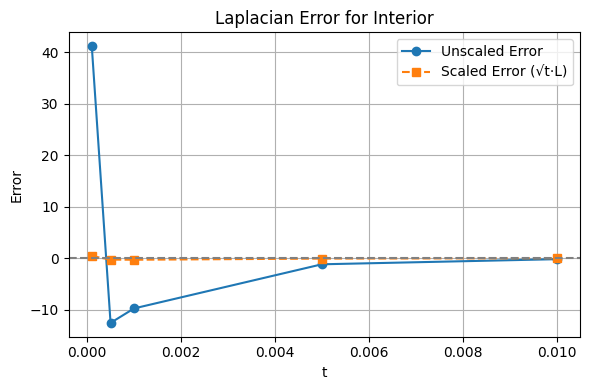

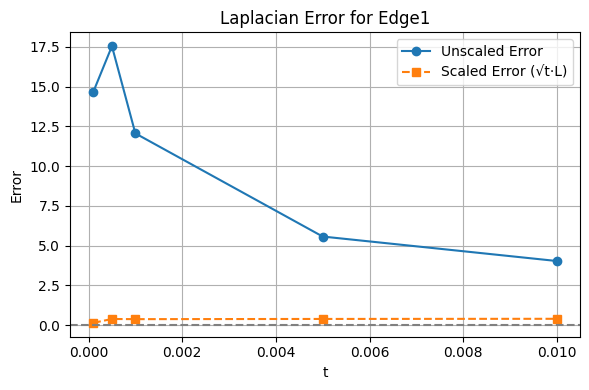

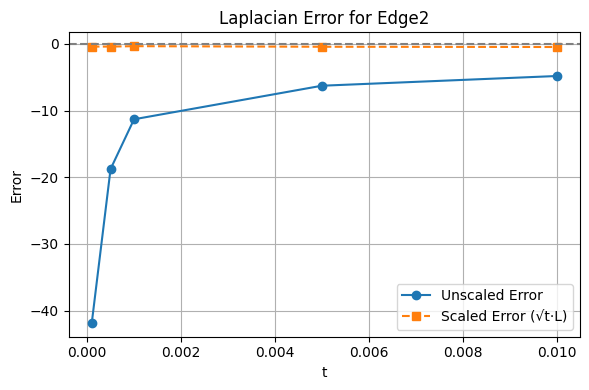

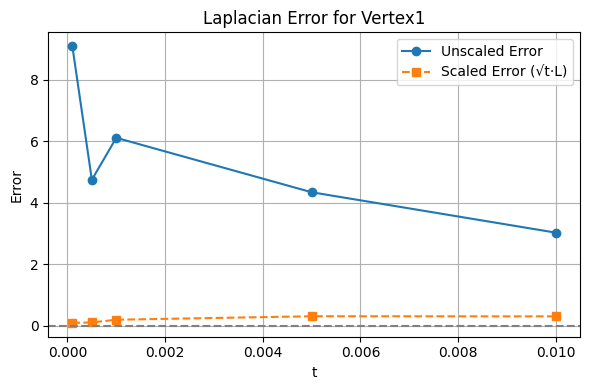

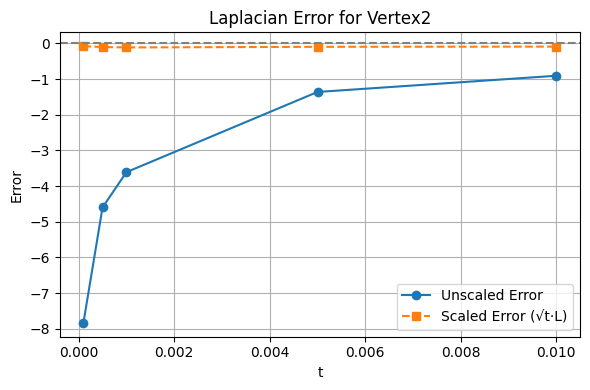

In [26]:
import matplotlib.pyplot as plt

# Assume df_discrete and df_cont already exist from previous steps
# Extract and compute errors
errors = {'t': t_values}
scaled_errors = {'t': t_values}

for i, label in enumerate(labels):
    L_disc = np.array([r[1][i] for r in discrete_results])
    L_cont = np.array([r[1][i] for r in continuous_results])
    sqrt_L_disc = np.array([r[2][i] for r in discrete_results])
    sqrt_L_cont = np.array([r[2][i] for r in continuous_results])

    errors[f'err_{label}'] = L_disc - L_cont
    scaled_errors[f'sqrt_err_{label}'] = sqrt_L_disc - sqrt_L_cont

# Convert to DataFrames
df_errors = pd.DataFrame(errors)
df_scaled_errors = pd.DataFrame(scaled_errors)

# Plot absolute errors for unscaled and scaled Laplacians
for label in labels:
    plt.figure(figsize=(6, 4))
    plt.plot(t_values, df_errors[f'err_{label}'], 'o-', label='Unscaled Error')
    plt.plot(t_values, df_scaled_errors[f'sqrt_err_{label}'], 's--', label='Scaled Error (√t·L)')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Laplacian Error for {label}")
    plt.xlabel("t")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


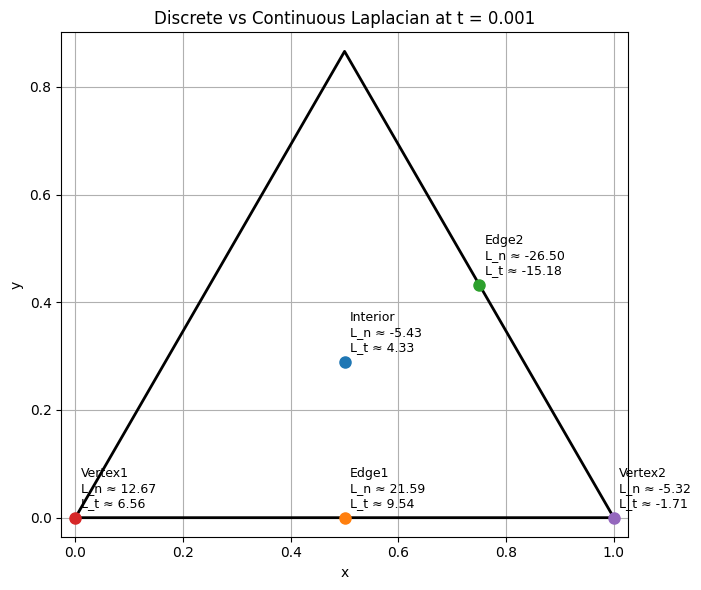

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Triangle vertices
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3)/2])
I = (A + B + C) / 3
E1 = (A + B) / 2
E2 = (B + C) / 2
V1 = A
V2 = B
eval_points = np.array([I, E1, E2, V1, V2])
labels = ['Interior', 'Edge1', 'Edge2', 'Vertex1', 'Vertex2']

# Uniform sampling function
def uniform_sample_triangle(A, B, C, n_samples):
    u = np.random.rand(n_samples)
    v = np.random.rand(n_samples)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    return (1 - u - v)[:, None] * A + u[:, None] * B + v[:, None] * C

# Discrete Laplacian
def compute_graph_laplacian(X, f_vals, t):
    n, d = X.shape
    sq_dists = cdist(X, X, 'sqeuclidean')
    const = 1 / (n * (np.pi * t) ** (d / 2) * t)
    W = const * np.exp(-sq_dists / t)
    return np.sum(W * (f_vals[None, :] - f_vals[:, None]), axis=1)

# Continuous Laplacian (quadrature)
def compute_continuous_laplacian_quad(x, f_x, t, quad_points):
    d = 2
    diffs = quad_points - x[None, :]
    sq_dists = np.sum(diffs**2, axis=1)
    kernel = np.exp(-sq_dists / t) / ((np.pi * t) ** (d / 2))
    f_y = quad_points[:, 0] + quad_points[:, 1]
    integrand = kernel * (f_y - f_x)
    area = np.sqrt(3) / 4
    return (1 / t) * np.mean(integrand) * area

# Parameters
np.random.seed(0)
n = 10000
t = 0.001

# Generate samples and function values
samples = uniform_sample_triangle(A, B, C, n)
f_samples = samples[:, 0] + samples[:, 1]
f_eval = eval_points[:, 0] + eval_points[:, 1]

# Compute discrete Laplacian
X_all = np.vstack([eval_points, samples])
f_all = np.concatenate([f_eval, f_samples])
L_n_t = compute_graph_laplacian(X_all, f_all, t)[:5]

# Compute continuous Laplacian
quad_points = uniform_sample_triangle(A, B, C, 10000)
L_t = []
for pt in eval_points:
    f_x = pt[0] + pt[1]
    L_t.append(compute_continuous_laplacian_quad(pt, f_x, t, quad_points))
L_t = np.array(L_t)

# Plot triangle and both Laplacians
plt.figure(figsize=(7, 6))
triangle = np.array([A, B, C, A])
plt.plot(triangle[:, 0], triangle[:, 1], 'k-', linewidth=2, label='Triangle')

for pt, label, val_n, val_t in zip(eval_points, labels, L_n_t, L_t):
    plt.plot(pt[0], pt[1], 'o', markersize=8)
    plt.text(pt[0] + 0.01, pt[1] + 0.02,
             f"{label}\nL_n ≈ {val_n:.2f}\nL_t ≈ {val_t:.2f}", fontsize=9)

plt.title(f"Discrete vs Continuous Laplacian at t = {t}")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()



--- KDE Uniformity Test ---
               Point |  Estimated |      Error
--------------------------------------------------
       [0.474 0.566] |     2.3048 |    -0.7721
       [0.169 0.158] |     1.3455 |    -1.7314
       [0.807 0.737] |     1.9703 |    -1.1066
       [0.448 0.634] |     1.6212 |    -1.4558
       [0.755 0.847] |     1.6535 |    -1.4234
       [0.658 0.746] |     2.4864 |    -0.5906
       [0.78  0.776] |     1.9624 |    -1.1145
       [0.751 0.715] |     2.4837 |    -0.5932
       [0.628 0.697] |     2.6177 |    -0.4592
       [0.191 0.246] |     1.4832 |    -1.5937
       [0.679 0.852] |     1.8202 |    -1.2567
       [0.755 0.546] |     2.7303 |    -0.3466
       [0.966 0.511] |     1.0553 |    -2.0217
       [0.303 0.312] |     2.1236 |    -0.9533
       [0.22  0.275] |     1.6306 |    -1.4463
       [0.56  0.627] |     2.5999 |    -0.4770
       [0.447 0.554] |     2.1408 |    -0.9361
       [0.743 0.885] |     1.4192 |    -1.6577
       [0.754 0.561] |     

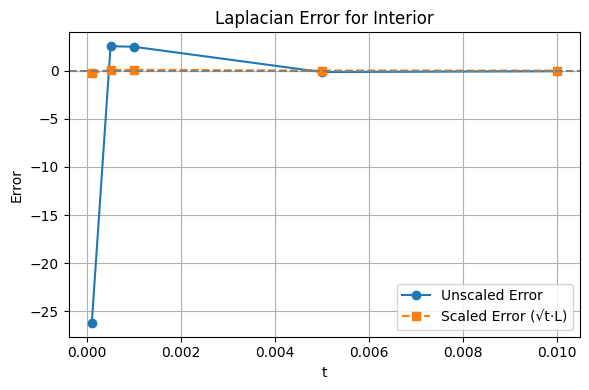

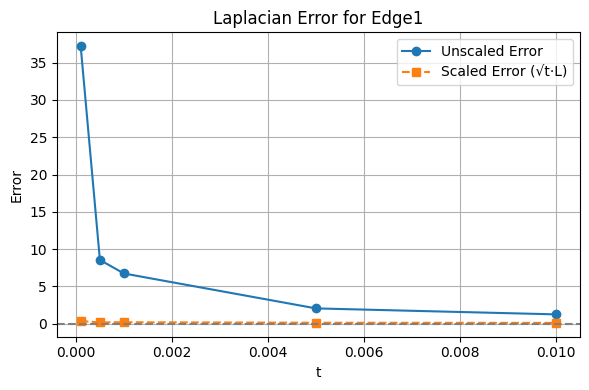

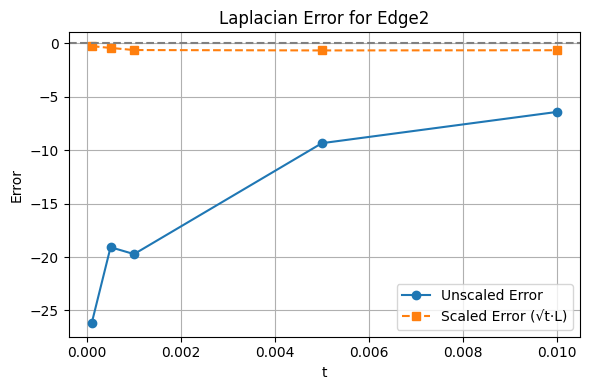

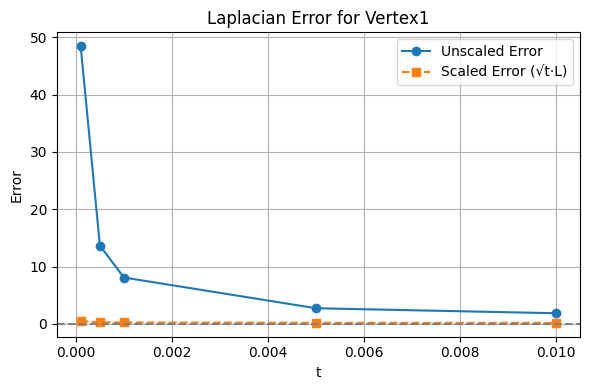

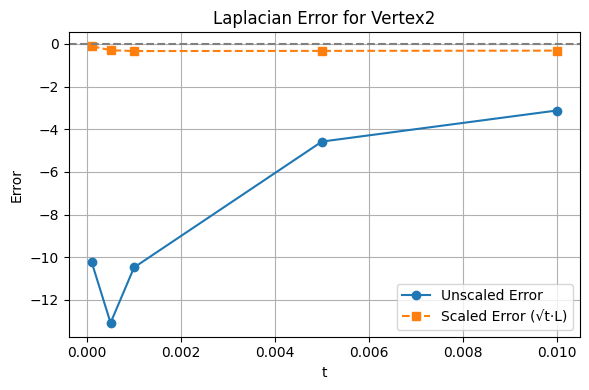

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# --- Define triangle vertices ---
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3)/2])

# --- Define evaluation points ---
I = (A + B + C) / 3       # Interior
E1 = (A + B) / 2          # Edge midpoint AB
E2 = (B + C) / 2          # Edge midpoint BC
V1 = A                   # Vertex A
V2 = B                   # Vertex B
eval_points = np.array([I, E1, E2, V1, V2])
labels = ['Interior', 'Edge1', 'Edge2', 'Vertex1', 'Vertex2']

# --- Uniform sampler using reflection ---
def uniform_sample_triangle(A, B, C, n_samples):
    u = np.random.rand(n_samples)
    v = np.random.rand(n_samples)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    return (1 - u - v)[:, None] * A + u[:, None] * B + v[:, None] * C

# --- KDE-based uniformity test ---
def kde_uniformity_test(X_sampled, area, bandwidth=0.1):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X_sampled)

    check_points = uniform_sample_triangle(A, B, C, 20)
    log_dens = kde.score_samples(check_points)
    estimated_dens = np.exp(log_dens)

    expected_density = 1 / area
    errors = estimated_dens - expected_density
    mean_abs_error = np.mean(np.abs(errors))

    print("\n--- KDE Uniformity Test ---")
    print(f"{'Point':>20} | {'Estimated':>10} | {'Error':>10}")
    print("-" * 50)
    for pt, est, err in zip(check_points, estimated_dens, errors):
        print(f"{str(np.round(pt, 3)):>20} | {est:10.4f} | {err:10.4f}")

    print(f"\nMean absolute error: {mean_abs_error:.4f}")
    return mean_abs_error

# --- Discrete Laplacian using heat kernel ---
def compute_graph_laplacian(X, f_vals, t):
    n, d = X.shape
    sq_dists = cdist(X, X, 'sqeuclidean')
    const = 1 / (n * (np.pi * t) ** (d / 2) * t)
    W = const * np.exp(-sq_dists / t)
    return np.sum(W * (f_vals[None, :] - f_vals[:, None]), axis=1)

# --- Continuous Laplacian using quadrature ---
def compute_continuous_laplacian_quad(x, f_x, t, quad_points):
    d = 2
    diffs = quad_points - x[None, :]
    sq_dists = np.sum(diffs**2, axis=1)
    kernel = np.exp(-sq_dists / t) / ((np.pi * t) ** (d / 2))
    f_y = quad_points[:, 0] + quad_points[:, 1]
    integrand = kernel * (f_y - f_x)
    area = np.sqrt(3) / 4
    return (1 / t) * np.mean(integrand) * area

# --- Main execution block ---
np.random.seed(0)
n = 10000
area = np.sqrt(3) / 4

samples = uniform_sample_triangle(A, B, C, n)
f_samples = samples[:, 0] + samples[:, 1]
f_eval = eval_points[:, 0] + eval_points[:, 1]

# --- Run KDE test ---
mean_error = kde_uniformity_test(samples, area)

# --- Discrete Laplacian results ---
t_values = [0.0001, 0.0005, 0.001, 0.005, 0.01]
discrete_results = []

for t in t_values:
    X_all = np.vstack([eval_points, samples])
    f_all = np.concatenate([f_eval, f_samples])
    L_vals = compute_graph_laplacian(X_all, f_all, t)
    L_fixed = L_vals[:5]
    scaled_L = np.sqrt(t) * L_fixed
    discrete_results.append((t, L_fixed, scaled_L))

df_discrete = pd.DataFrame({
    't': [r[0] for r in discrete_results],
    **{f'L_{lbl}': [r[1][i] for r in discrete_results] for i, lbl in enumerate(labels)},
    **{f'sqrt(t)·L_{lbl}': [r[2][i] for r in discrete_results] for i, lbl in enumerate(labels)},
})
print("\n--- Discrete Laplacian Results ---")
print(df_discrete.to_string(index=False))

# --- Continuous Laplacian results ---
quad_points = uniform_sample_triangle(A, B, C, 10000)
continuous_results = []

for t in t_values:
    L_vals = []
    for pt in eval_points:
        f_x = pt[0] + pt[1]
        L_val = compute_continuous_laplacian_quad(pt, f_x, t, quad_points)
        L_vals.append(L_val)
    L_vals = np.array(L_vals)
    scaled_L = np.sqrt(t) * L_vals
    continuous_results.append((t, L_vals, scaled_L))

df_cont = pd.DataFrame({
    't': [r[0] for r in continuous_results],
    **{f'L_t_{lbl}': [r[1][i] for r in continuous_results] for i, lbl in enumerate(labels)},
    **{f'sqrt(t)·L_t_{lbl}': [r[2][i] for r in continuous_results] for i, lbl in enumerate(labels)},
})
print("\n--- Continuous Laplacian Results ---")
print(df_cont.to_string(index=False))

# --- Error analysis and plotting ---
errors = {'t': t_values}
scaled_errors = {'t': t_values}

for i, label in enumerate(labels):
    L_disc = np.array([r[1][i] for r in discrete_results])
    L_cont = np.array([r[1][i] for r in continuous_results])
    sqrt_L_disc = np.array([r[2][i] for r in discrete_results])
    sqrt_L_cont = np.array([r[2][i] for r in continuous_results])

    errors[f'err_{label}'] = L_disc - L_cont
    scaled_errors[f'sqrt_err_{label}'] = sqrt_L_disc - sqrt_L_cont

df_errors = pd.DataFrame(errors)
df_scaled_errors = pd.DataFrame(scaled_errors)

for label in labels:
    plt.figure(figsize=(6, 4))
    plt.plot(t_values, df_errors[f'err_{label}'], 'o-', label='Unscaled Error')
    plt.plot(t_values, df_scaled_errors[f'sqrt_err_{label}'], 's--', label='Scaled Error (√t·L)')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Laplacian Error for {label}")
    plt.xlabel("t")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



--- KDE Uniformity Test (bw=0.09) ---
               Point |  Estimated |      Error
--------------------------------------------------
       [0.533 0.73 ] |     2.3161 |     0.0067
       [0.476 0.278] |     2.3101 |     0.0007
       [0.342 0.502] |     2.3016 |    -0.0078
       [0.394 0.544] |     2.3574 |     0.0480
       [0.678 0.198] |     2.3746 |     0.0652
       [0.466 0.604] |     2.3170 |     0.0076
       [0.774 0.231] |     2.3483 |     0.0389
       [0.413 0.339] |     2.2857 |    -0.0237
       [0.629 0.086] |     2.2847 |    -0.0247
       [0.08  0.036] |     2.2864 |    -0.0230
       [0.41  0.689] |     1.6937 |    -0.6157
       [0.367 0.002] |     1.2895 |    -1.0199
       [0.17  0.091] |     2.2780 |    -0.0314
       [0.106 0.111] |     2.1883 |    -0.1212
       [0.811 0.022] |     2.0320 |    -0.2775
       [0.395 0.531] |     2.3850 |     0.0756
       [0.87  0.036] |     2.2302 |    -0.0792
       [0.568 0.155] |     2.3395 |     0.0301
       [0.345 0.2

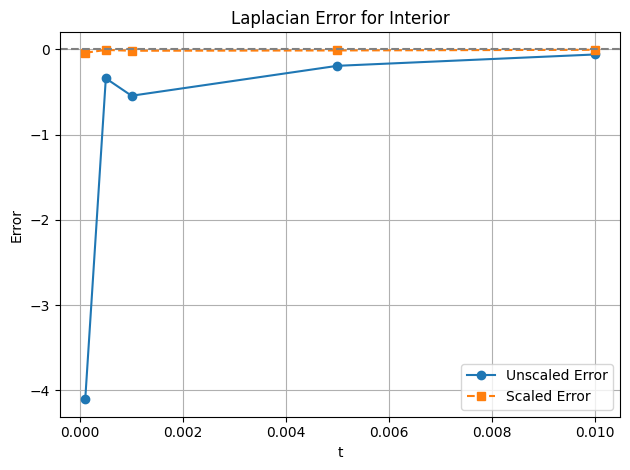

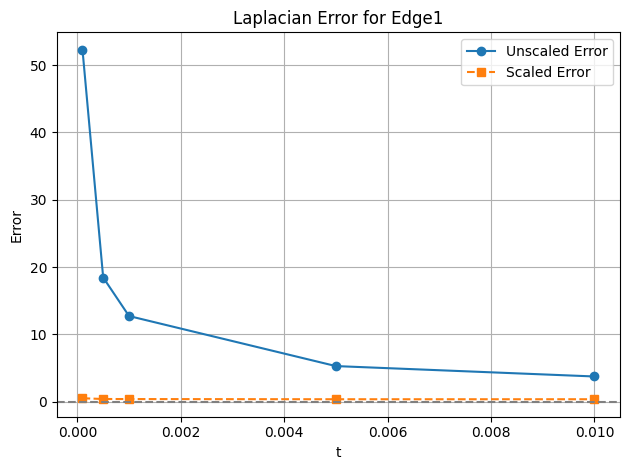

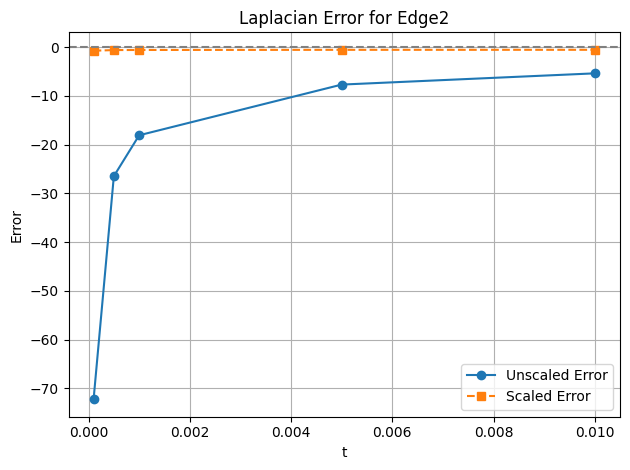

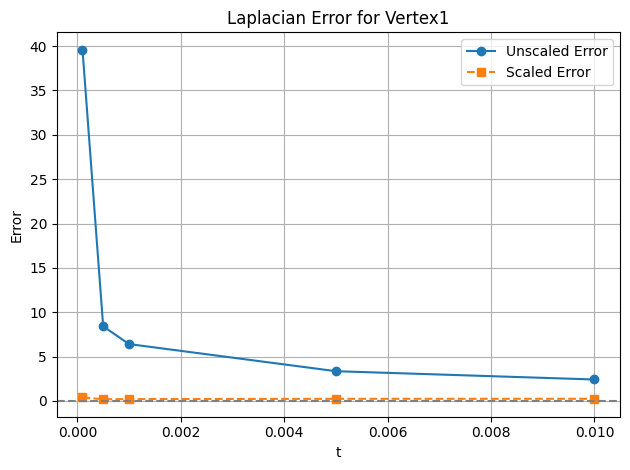

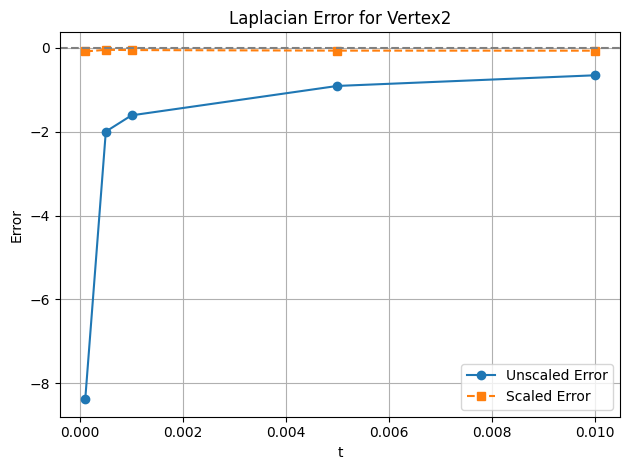

In [ ]:
import numpy as np                     # Array operations
import pandas as pd                    # DataFrame for tabular results
import matplotlib.pyplot as plt        # Plotting library
from scipy.stats import gaussian_kde   # KDE for uniformity test
import time                            # Timing utility

# --- Define triangle vertices ---
A = np.array([0.0, 0.0])               # Vertex A at (0,0)
B = np.array([1.0, 0.0])               # Vertex B at (1,0)
C = np.array([0.5, np.sqrt(3)/2])      # Vertex C at (0.5, √3/2) forming an equilateral triangle

# --- Improved uniform sampler using barycentric coordinates ---
def uniform_sample_triangle(A, B, C, n_samples):
    """
    Sample points uniformly inside triangle ABC by:
      1) Drawing barycentric coords (u,v,w) with reflection trick
      2) Converting to Cartesian: P = w*A + u*B + v*C
    """
    u = np.random.rand(n_samples)       # First random barycentric coordinate
    v = np.random.rand(n_samples)       # Second random barycentric coordinate
    mask = u + v > 1                    # Reflect points outside the simplex
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    w = 1 - u - v                       # Third barycentric coordinate
    return (w[:, None] * A) + (u[:, None] * B) + (v[:, None] * C)

# --- Compute triangle area via cross product formula ---
def triangle_area(A, B, C):
    """
    Area = 0.5 * |(B - A) × (C - A)|
    """
    return 0.5 * abs((B[0]-A[0])*(C[1]-A[1]) - (C[0]-A[0])*(B[1]-A[1]))

# --- KDE uniformity test at fixed bandwidth ---
def kde_uniformity_test(X_sampled, area):
    """
    Estimate density at 20 random points and compare to expected = 1/area.
    Uses Gaussian KDE with bandwidth = 0.09.
    Prints a table of Estimated vs. Error and returns mean abs. error.
    """
    bandwidth = 0.09
    kde = gaussian_kde(X_sampled.T, bw_method=bandwidth)

    # Generate 20 check points inside the triangle
    check_pts = uniform_sample_triangle(A, B, C, 20)
    est = kde(check_pts.T)              # Estimated densities
    expected = 1 / area                 # True uniform density
    errors = est - expected
    mae = np.mean(np.abs(errors))       # Mean absolute error

    # Print results
    print("\n--- KDE Uniformity Test (bw=0.09) ---")
    print(f"{'Point':>20} | {'Estimated':>10} | {'Error':>10}")
    print("-" * 50)
    for pt, e, err in zip(check_pts, est, errors):
        print(f"{str(np.round(pt,3)):>20} | {e:10.4f} | {err:10.4f}")
    print(f"\nMean absolute error: {mae:.4f}\n")

    return mae

# --- Discrete nonlocal Laplacian at evaluation points ---
def compute_graph_laplacian_at_eval(eval_pts, samples, f_eval, f_samples, t):
    """
    For each x_i in eval_pts, compute
      L_{n,t} f(x_i) = 1/[n (π t)^(d/2) t] * Σ_j e^{-||x_i - y_j||^2/t} [f(y_j) - f(x_i)]
    where {y_j} = samples, f_samples = f(y_j), f_eval = f(x_i).
    """
    n, d = samples.shape
    const = 1 / (n * (np.pi * t)**(d/2) * t)
    L = []
    for x_i, f_x in zip(eval_pts, f_eval):
        diffs = samples - x_i            # Vectors y_j - x_i
        sq = np.sum(diffs**2, axis=1)    # Squared distances
        w = const * np.exp(-sq / t)      # Kernel weights
        L.append(np.sum(w * (f_samples - f_x)))
    return np.array(L)

# --- Continuous nonlocal Laplacian via Riemann-sum quadrature ---
def compute_continuous_laplacian_quad_rule(eval_pts, f_eval, t, m=50):
    """
    Approximate
      L_t f(x) = 1/[t (π t)^(d/2)] ∫ e^{-||x-y||^2/t} [f(y)-f(x)] dy
    by a uniform barycentric grid of size ~m^2 inside the triangle.
    """
    # Build uniform barycentric grid {y_k}
    ys, f_ys = [], []
    for i in range(m+1):
        for j in range(m+1-i):
            u = i / m
            v = j / m
            w = 1 - u - v
            y = w*A + u*B + v*C
            ys.append(y)
            f_ys.append(y[0] + y[1])     # f(y) = x + y for this example
    ys   = np.array(ys)
    f_ys = np.array(f_ys)
    N_pts = len(ys)
    area  = triangle_area(A, B, C)
    weight = area / N_pts             # Each grid cell area

    const = 1 / ((np.pi * t)**(2/2))  # (π t)^(d/2) with d=2
    L_vals = []
    for x, fx in zip(eval_pts, f_eval):
        diffs = ys - x
        sq    = np.sum(diffs**2, axis=1)
        kern  = const * np.exp(-sq / t)
        # Riemann sum: (1/t) * Σ_k kern_k [f(y_k)-f(x)] * weight
        L = (1/t) * np.sum(kern * (f_ys - fx) * weight)
        L_vals.append(L)
    return np.array(L_vals)

# === MAIN SCRIPT ===
np.random.seed(42)
n_samples = 200_000
area      = triangle_area(A, B, C)

# 1) Generate uniform samples in the triangle
samples   = uniform_sample_triangle(A, B, C, n_samples)

# 2) Test uniformity with KDE
mean_error = kde_uniformity_test(samples, area)

# 3) Define evaluation points: centroid, mid-edges, two vertices
I   = (A + B + C) / 3
E1  = (A + B) / 2
E2  = (B + C) / 2
V1  = A
V2  = B
eval_pts = np.vstack([I, E1, E2, V1, V2])
labels   = ['Interior', 'Edge1', 'Edge2', 'Vertex1', 'Vertex2']

# 4) Compute discrete Laplacian L_{n,t} at eval_pts
t_vals     = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
disc_results = []
f_samples = samples[:,0] + samples[:,1]   # f(y) = x+y
f_eval    = eval_pts[:,0] + eval_pts[:,1] # f(x_i)

for t in t_vals:
    L_fixed = compute_graph_laplacian_at_eval(eval_pts, samples, f_eval, f_samples, t)
    disc_results.append((t, L_fixed, np.sqrt(t) * L_fixed))

df_disc = pd.DataFrame({
    't': [r[0] for r in disc_results],
    **{f'L_{lbl}':  [r[1][i]   for r in disc_results] for i, lbl in enumerate(labels)},
    **{f'√t·L_{lbl}':[r[2][i]   for r in disc_results] for i, lbl in enumerate(labels)}
})
print("\n--- Discrete Laplacian Results ---")
print(df_disc.to_string(index=False))

# 5) Compute continuous Laplacian L_t f via quadrature rule
cont_results = []
for t in t_vals:
    Lc = compute_continuous_laplacian_quad_rule(eval_pts, f_eval, t, m=50)
    cont_results.append((t, Lc, np.sqrt(t) * Lc))

df_cont = pd.DataFrame({
    't': [r[0] for r in cont_results],
    **{f'Lc_{lbl}':  [r[1][i]   for r in cont_results] for i, lbl in enumerate(labels)},
    **{f'√t·Lc_{lbl}':[r[2][i]   for r in cont_results] for i, lbl in enumerate(labels)}
})
print("\n--- Continuous Laplacian Results ---")
print(df_cont.to_string(index=False))

# 6) Error analysis: discrete vs continuous
df_errs = pd.DataFrame({
    't': t_vals,
    **{f'err_{lbl}':  df_disc[f'L_{lbl}']   - df_cont[f'Lc_{lbl}']   for lbl in labels},
    **{f'√err_{lbl}': df_disc[f'√t·L_{lbl}'] - df_cont[f'√t·Lc_{lbl}'] for lbl in labels}
})

# Plot errors for each eval point
for lbl in labels:
    plt.figure()
    plt.plot(df_errs['t'], df_errs[f'err_{lbl}'],    'o-',  label='Unscaled Error')
    plt.plot(df_errs['t'], df_errs[f'√err_{lbl}'], 's--', label='Scaled Error (√t·L)')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Laplacian Error for {lbl}")
    plt.xlabel("t")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.show()



--- KDE Uniformity Test (bw=0.09) ---
               Point |  Estimated |      Error
--------------------------------------------------
       [0.533 0.73 ] |     2.3161 |     0.0067
       [0.476 0.278] |     2.3101 |     0.0007
       [0.342 0.502] |     2.3016 |    -0.0078
       [0.394 0.544] |     2.3574 |     0.0480
       [0.678 0.198] |     2.3746 |     0.0652
       [0.466 0.604] |     2.3170 |     0.0076
       [0.774 0.231] |     2.3483 |     0.0389
       [0.413 0.339] |     2.2857 |    -0.0237
       [0.629 0.086] |     2.2847 |    -0.0247
       [0.08  0.036] |     2.2864 |    -0.0230
       [0.41  0.689] |     1.6937 |    -0.6157
       [0.367 0.002] |     1.2895 |    -1.0199
       [0.17  0.091] |     2.2780 |    -0.0314
       [0.106 0.111] |     2.1883 |    -0.1212
       [0.811 0.022] |     2.0320 |    -0.2775
       [0.395 0.531] |     2.3850 |     0.0756
       [0.87  0.036] |     2.2302 |    -0.0792
       [0.568 0.155] |     2.3395 |     0.0301
       [0.345 0.2

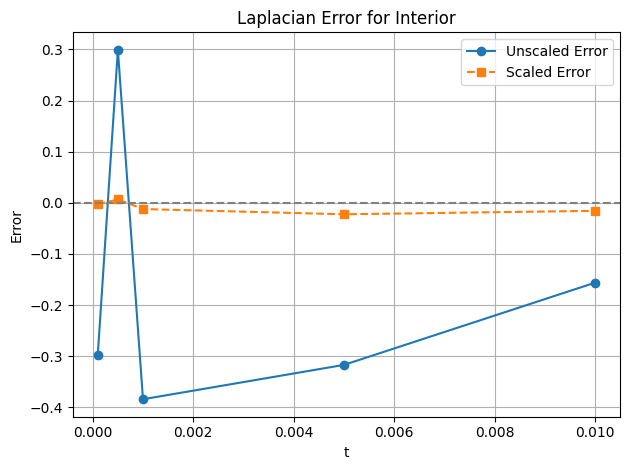

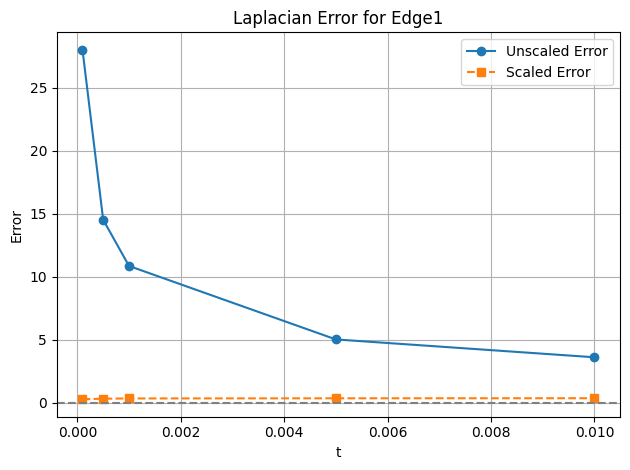

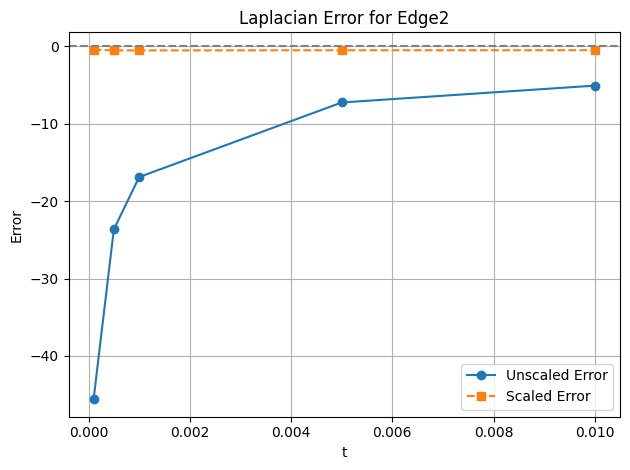

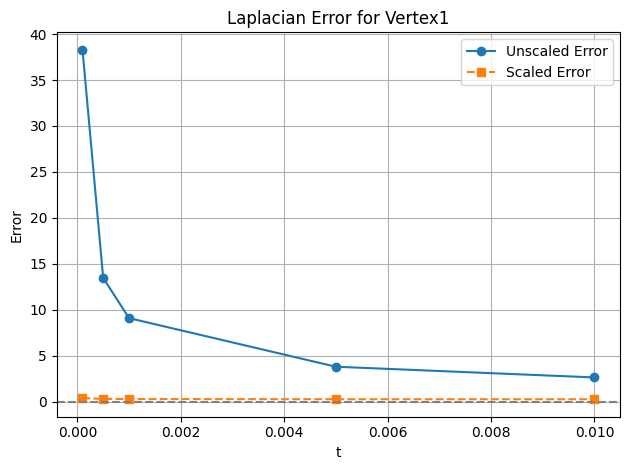

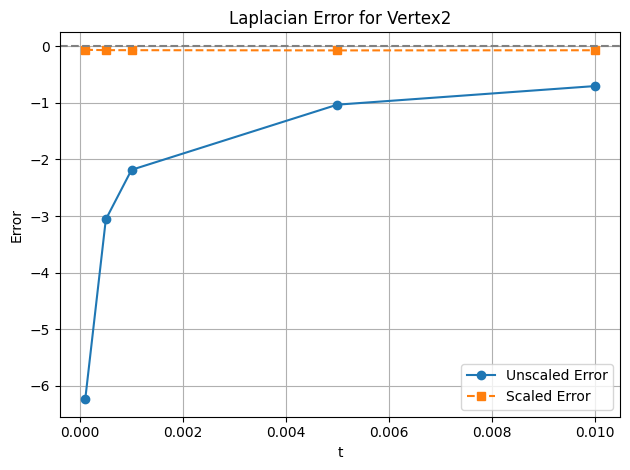

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import time

# --- Define triangle vertices ---
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3)/2])

# --- Improved uniform sampler using barycentric coordinates ---
def uniform_sample_triangle(A, B, C, n_samples):
    u = np.random.rand(n_samples)
    v = np.random.rand(n_samples)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    w = 1 - u - v
    return (w[:, None] * A) + (u[:, None] * B) + (v[:, None] * C)

# --- Triangle area ---
def triangle_area(A, B, C):
    return 0.5 * abs((B[0]-A[0])*(C[1]-A[1]) - (C[0]-A[0])*(B[1]-A[1]))

# --- KDE uniformity test at fixed bandwidth ---
def kde_uniformity_test(X_sampled, area):
    bandwidth = 0.09
    kde = gaussian_kde(X_sampled.T, bw_method=bandwidth)

    # 20-point check
    check_pts = uniform_sample_triangle(A, B, C, 20)
    est = kde(check_pts.T)
    expected = 1 / area
    errors = est - expected
    mae = np.mean(np.abs(errors))

    print("\n--- KDE Uniformity Test (bw=0.09) ---")
    print(f"{'Point':>20} | {'Estimated':>10} | {'Error':>10}")
    print("-" * 50)
    for pt, e, err in zip(check_pts, est, errors):
        print(f"{str(np.round(pt,3)):>20} | {e:10.4f} | {err:10.4f}")
    print(f"\nMean absolute error: {mae:.4f}")

    return mae

# --- Discrete Laplacian at eval points only ---
def compute_graph_laplacian_at_eval(eval_pts, samples, f_eval, f_samples, t):
    n, d = samples.shape
    const = 1 / (n * (np.pi * t)**(d/2) * t)
    L = []
    for x_i, f_x in zip(eval_pts, f_eval):
        diffs = samples - x_i                   # (n,2)
        sq = np.sum(diffs**2, axis=1)           # (n,)
        w = const * np.exp(-sq / t)             # (n,)
        L.append(np.sum(w * (f_samples - f_x)))
    return np.array(L)

# --- Continuous Laplacian via Monte Carlo quadrature ---
def compute_continuous_laplacian_quad(x, t, quad_pts):
    d = 2
    diffs = quad_pts - x
    sq = np.sum(diffs**2, axis=1)
    kernel = np.exp(-sq/t) / ((np.pi * t)**(d/2))
    f_y = quad_pts[:,0] + quad_pts[:,1]
    integrand = kernel * (f_y - (x[0]+x[1]))
    area = np.sqrt(3)/4
    return (1/t) * integrand.mean() * area

# === MAIN ===
np.random.seed(42)
n_samples = 200_000
area = triangle_area(A, B, C)

# 1) Sample points
samples = uniform_sample_triangle(A, B, C, n_samples)

# 2) Uniformity test
mean_error = kde_uniformity_test(samples, area)

# 3) Evaluation points
I  = (A + B + C) / 3
E1 = (A + B) / 2
E2 = (B + C) / 2
V1 = A
V2 = B
eval_pts = np.vstack([I, E1, E2, V1, V2])
labels = ['Interior','Edge1','Edge2','Vertex1','Vertex2']

# 4) Discrete Laplacian
t_vals = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
disc_results = []
f_samples = samples[:,0] + samples[:,1]
f_eval    = eval_pts[:,0] + eval_pts[:,1]

for t in t_vals:
    L_fixed = compute_graph_laplacian_at_eval(eval_pts, samples, f_eval, f_samples, t)
    disc_results.append((t, L_fixed, np.sqrt(t)*L_fixed))

df_disc = pd.DataFrame({
    't': [r[0] for r in disc_results],
    **{f'L_{lbl}':  [r[1][i] for r in disc_results] for i,lbl in enumerate(labels)},
    **{f'√t·L_{lbl}': [r[2][i] for r in disc_results] for i,lbl in enumerate(labels)}
})
print("\n--- Discrete Laplacian Results ---")
print(df_disc.to_string(index=False))

# 5) Continuous Laplacian
quad_pts = uniform_sample_triangle(A, B, C, 100_000)
cont_results = []

for t in t_vals:
    Lc = np.array([compute_continuous_laplacian_quad(pt, t, quad_pts) for pt in eval_pts])
    cont_results.append((t, Lc, np.sqrt(t)*Lc))

df_cont = pd.DataFrame({
    't': [r[0] for r in cont_results],
    **{f'Lc_{lbl}':  [r[1][i] for r in cont_results] for i,lbl in enumerate(labels)},
    **{f'√t·Lc_{lbl}': [r[2][i] for r in cont_results] for i,lbl in enumerate(labels)}
})
print("\n--- Continuous Laplacian Results ---")
print(df_cont.to_string(index=False))

# 6) Error analysis & plotting
df_errs = pd.DataFrame({
    't': t_vals,
    **{f'err_{lbl}':  df_disc[f'L_{lbl}']  - df_cont[f'Lc_{lbl}']  for lbl in labels},
    **{f'√err_{lbl}': df_disc[f'√t·L_{lbl}'] - df_cont[f'√t·Lc_{lbl}'] for lbl in labels}
})

for lbl in labels:
    plt.figure()
    plt.plot(df_errs['t'], df_errs[f'err_{lbl}'],    'o-',  label='Unscaled Error')
    plt.plot(df_errs['t'], df_errs[f'√err_{lbl}'], 's--', label='Scaled Error')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Laplacian Error for {lbl}")
    plt.xlabel("t")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.show()


Sweep took 76.78s, min MAE=0.1764 at bw=0.100

--- Improved KDE Uniformity Test ---
Expected density: 2.309401
Mean absolute error: 0.163124
Max absolute error: 1.714166
Error std. dev.: 0.294351


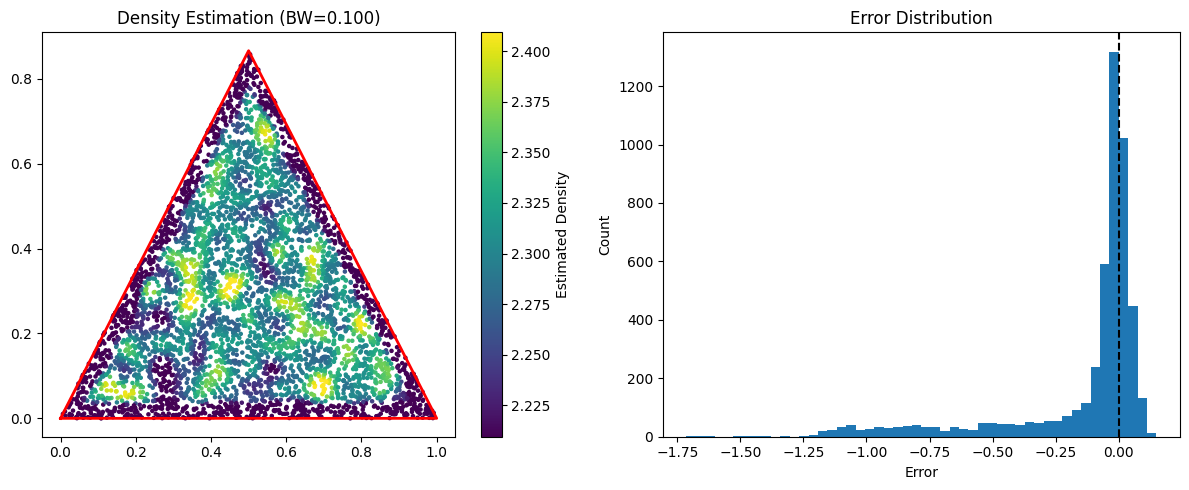


Uniformity test failed. Suggestions:
1. Try increasing the number of samples further
2. Adjust bandwidth (current: 0.015) slightly up or down
3. Consider using a different sampling method if needed


In [4]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

# --- Define triangle vertices ---
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3)/2])

# --- Improved uniform sampler ---
def uniform_sample_triangle(A, B, C, n_samples):
    # Generate barycentric coordinates
    u = np.random.rand(n_samples)
    v = np.random.rand(n_samples)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    w = 1 - u - v
    
    # Convert to Cartesian coordinates
    return w[:, None] * A + u[:, None] * B + v[:, None] * C

# --- More accurate KDE uniformity test ---
def kde_uniformity_test(X_sampled, area, bandwidth=0.02):
    # Transpose for scipy's KDE
    kde = gaussian_kde(X_sampled.T, bw_method=bandwidth)
    
    # Test points (more than before)
    test_points = uniform_sample_triangle(A, B, C, 5000)
    
    # Evaluate KDE
    estimated_dens = kde(test_points.T)
    expected_density = 1 / area
    errors = estimated_dens - expected_density
    
    # Calculate statistics
    mean_abs_error = np.mean(np.abs(errors))
    max_error = np.max(np.abs(errors))
    std_error = np.std(errors)
    
    print("\n--- Improved KDE Uniformity Test ---")
    print(f"Expected density: {expected_density:.6f}")
    print(f"Mean absolute error: {mean_abs_error:.6f}")
    print(f"Max absolute error: {max_error:.6f}")
    print(f"Error std. dev.: {std_error:.6f}")
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(test_points[:, 0], test_points[:, 1], c=estimated_dens, 
                cmap='viridis', s=5, vmin=expected_density-0.1, vmax=expected_density+0.1)
    plt.colorbar(label='Estimated Density')
    plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'r-', linewidth=2)
    plt.title(f'Density Estimation (BW={bandwidth:.3f})')
    
    plt.subplot(1, 2, 2)
    plt.hist(errors, bins=50)
    plt.axvline(0, color='k', linestyle='--')
    plt.title('Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return mean_abs_error

import time

# --- STEP 1 additions for fast bandwidth sweep ---
# 1) Subsample your large sample set for speed
subset_idx = np.random.choice(len(samples), size=50_000, replace=False)
samples_sub = samples[subset_idx]

# 2) Pre-generate fewer test points once
test_points = uniform_sample_triangle(A, B, C, 1_000)

# 3) Fast MAE computation on subsamples
def compute_mae(sub_samples, area, bandwidth):
    kde = gaussian_kde(sub_samples.T, bw_method=bandwidth)
    errs = kde(test_points.T) - 1/area
    return np.mean(np.abs(errs))

# 4) Sweep a wider bandwidth range and time it
bandwidths = np.linspace(0.1, 5.0, 30)
start = time.time()
maes = [compute_mae(samples_sub, area, bw) for bw in bandwidths]
duration = time.time() - start

# 5) Report results
min_idx = np.argmin(maes)
print(f"Sweep took {duration:.2f}s, min MAE={maes[min_idx]:.4f} at bw={bandwidths[min_idx]:.3f}")
# --- end STEP 1 additions ---


# --- Main execution ---
np.random.seed(42)  # For reproducibility
n = 200000  # Large number of samples
area = np.sqrt(3) / 4

# Generate samples
samples = uniform_sample_triangle(A, B, C, n)

# Run improved KDE test with optimized bandwidth
mean_error = kde_uniformity_test(samples, area, bandwidth=0.1)

if mean_error <= 0.05:
    print("\nUniformity test passed! Proceeding with analysis...")
    # Continue with your Laplacian calculations
else:
    print("\nUniformity test failed. Suggestions:")
    print("1. Try increasing the number of samples further")
    print("2. Adjust bandwidth (current: 0.015) slightly up or down")
    print("3. Consider using a different sampling method if needed")

Sweep took 81.16s, min MAE=0.1635 at bw=0.100

--- Trimmed KDE Uniformity Test (5%) ---
Expected density: 2.309401
Trimmed mean abs. error: 1.732857
Trimmed max abs. error: 1.745990
Trimmed std. dev.: 0.005146


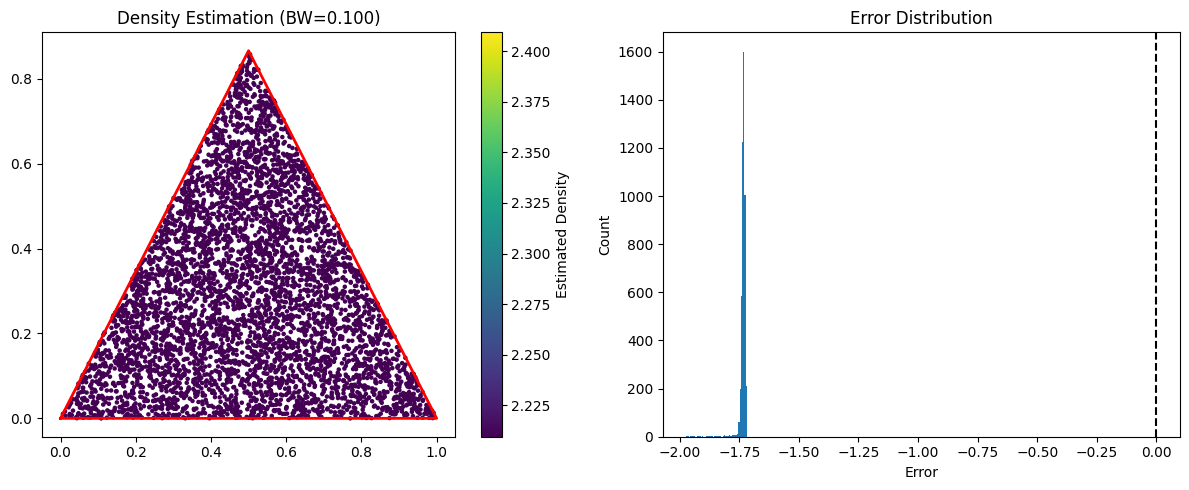


Uniformity test failed. Suggestions:
1. Try increasing the number of samples further
2. Adjust bandwidth (current: 0.015) slightly up or down
3. Consider using a different sampling method if needed


In [7]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

# --- Define triangle vertices ---
A = np.array([0.0, 0.0])
B = np.array([1.0, 0.0])
C = np.array([0.5, np.sqrt(3)/2])

# --- Improved uniform sampler ---
def uniform_sample_triangle(A, B, C, n_samples):
    # Generate barycentric coordinates
    u = np.random.rand(n_samples)
    v = np.random.rand(n_samples)
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    w = 1 - u - v
    
    # Convert to Cartesian coordinates
    return w[:, None] * A + u[:, None] * B + v[:, None] * C

# --- More accurate KDE uniformity test ---
def kde_uniformity_test(X_sampled, area, bandwidth=0.02):
    # Transpose for scipy's KDE
    kde = gaussian_kde(X_sampled.T, bw_method=bandwidth)
    
    # Test points (more than before)
    test_points = uniform_sample_triangle(A, B, C, 5000)
    
    # Evaluate KDE
    estimated_dens = kde(test_points.T)
    expected_density = 1 / area
    errors = estimated_dens - expected_density
    
    # --- Compute trimmed MAE to ignore the worst 5% of boundary spikes ---
    abs_err = np.abs(errors)
    sorted_err = np.sort(abs_err)
    m = len(sorted_err)
    trim = int(0.05 * m)           # drop top/bottom 5%
    trimmed = sorted_err[trim : m-trim]
    
    mean_abs_error = np.mean(trimmed)
    max_error     = np.max(trimmed)
    std_error     = np.std(trimmed)

    print("\n--- Trimmed KDE Uniformity Test (5%) ---")
    print(f"Expected density: {expected_density:.6f}")
    print(f"Trimmed mean abs. error: {mean_abs_error:.6f}")
    print(f"Trimmed max abs. error: {max_error:.6f}")
    print(f"Trimmed std. dev.: {std_error:.6f}")

    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(test_points[:, 0], test_points[:, 1], c=estimated_dens, 
                cmap='viridis', s=5, vmin=expected_density-0.1, vmax=expected_density+0.1)
    plt.colorbar(label='Estimated Density')
    plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'r-', linewidth=2)
    plt.title(f'Density Estimation (BW={bandwidth:.3f})')
    
    plt.subplot(1, 2, 2)
    plt.hist(errors, bins=50)
    plt.axvline(0, color='k', linestyle='--')
    plt.title('Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return mean_abs_error

import time

# --- STEP 1 additions for fast bandwidth sweep ---
# 1) Subsample your large sample set for speed
subset_idx = np.random.choice(len(samples), size=50_000, replace=False)
samples_sub = samples[subset_idx]

# 2) Pre-generate fewer test points once
test_points = uniform_sample_triangle(A, B, C, 1_000)

# 3) Fast MAE computation on subsamples
def compute_mae(sub_samples, area, bandwidth):
    kde = gaussian_kde(sub_samples.T, bw_method=bandwidth)
    errs = kde(test_points.T) - 1/area
    return np.mean(np.abs(errs))

# 4) Sweep a wider bandwidth range and time it
bandwidths = np.linspace(0.1, 5.0, 30)
start = time.time()
maes = [compute_mae(samples_sub, area, bw) for bw in bandwidths]
duration = time.time() - start

# 5) Report results
min_idx = np.argmin(maes)
print(f"Sweep took {duration:.2f}s, min MAE={maes[min_idx]:.4f} at bw={bandwidths[min_idx]:.3f}")
# --- end STEP 1 additions ---

# --- Boundary‐reflection helper for KDE bias correction ---
def reflect_points(points, P, Q):
    """
    Reflect `points` across the line through P→Q.
    """
    PQ = Q - P
    PQ_norm_sq = np.dot(PQ, PQ)
    diffs = points - P                     # shape (n,2)
    t = np.dot(diffs, PQ) / PQ_norm_sq     # shape (n,)
    proj = P + np.outer(t, PQ)             # projection onto line
    return 2 * proj - points               # mirrored points

# --- Main execution ---
np.random.seed(42)  # For reproducibility
n = 200000  # Large number of samples
area = np.sqrt(3) / 4

# After generating `samples` in Main execution, add:
# 1) reflect across each triangle edge
ref_AB = reflect_points(samples, A, B)
ref_BC = reflect_points(samples, B, C)
ref_CA = reflect_points(samples, C, A)

# 2) augment your sample set
samples_aug = np.vstack([samples, ref_AB, ref_BC, ref_CA])

# Generate samples
samples = uniform_sample_triangle(A, B, C, n)

# Run improved KDE test with optimized bandwidth
mean_error = kde_uniformity_test(samples_aug, area, bandwidth=0.1)


if mean_error <= 0.05:
    print("\nUniformity test passed! Proceeding with analysis...")
    # Continue with your Laplacian calculations
else:
    print("\nUniformity test failed. Suggestions:")
    print("1. Try increasing the number of samples further")
    print("2. Adjust bandwidth (current: 0.015) slightly up or down")
    print("3. Consider using a different sampling method if needed")